# Setup

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
path = input("Enter the path:") 
os.chdir(path)


!ls

'Insights NYC.gdoc'		    'NYC Trip - Linear Models.ipynb'
 nyc_taxi_trip_duration.csv	    'Rough Work.ipynb'
'NYC Taxi Trip Duration EDA.ipynb'


In [ ]:
import numpy as np
from sklearn.feature_selection import chi2
import pandas as pd
import seaborn as sns
import time
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import normalize
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import cross_validate
import warnings
# from sklearn.preprocessing import Normalizer
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Loading Data

In [ ]:
df = pd.read_csv('nyc_taxi_trip_duration.csv')

# Treating missing values

In [ ]:
pd.isnull(df).sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

No missing values in this dataset. Yay!

In [ ]:
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Let us convert vendor_id into a categorical variable since it only has values 0 and 1(covered this in eda)

In [ ]:
df['vendor_id'] = df['vendor_id'].apply(lambda x:str(x))

In [ ]:
df.dtypes

id                     object
vendor_id              object
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

We can see that the vendor_id is converted into object type from int.From the EDA performed earlier, we came to conclusion that time related features provided key insights for trip duration, let's create these features once again.

# Create Distance feature

In [ ]:
df2 = df[['pickup_longitude' , 'pickup_latitude' , 'dropoff_longitude' , 'dropoff_latitude']]

import geopy.distance

temp = []

for i in range(0,df2.shape[0]):
  temp.append(geopy.distance.distance((df2['pickup_latitude'][i],df2['pickup_longitude'][i]),(df2['dropoff_latitude'][i],df2['dropoff_longitude'][i])).km)

df2['distance_km'] = temp
df2['distance_km'] = df2['distance_km'].apply(lambda x:round(x,2))

df['distance_km'] = df2['distance_km']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
df['distance_km'] .shape

(729322,)

# Creating new time related features 

Based on the length, datatype and value of the pickup timestamp, we can deduce year, month, day and hour as follows

In [ ]:
df['pickup_timestamp'] = df['pickup_datetime'].copy()

df['pickup_year'] = df['pickup_timestamp'].apply(lambda x:x[0:4])
df['pickup_month'] = df['pickup_timestamp'].apply(lambda x:x[5:7])
df['pickup_day'] = df['pickup_timestamp'].apply(lambda x:x[8:11])
df['pickup_hour'] = df['pickup_timestamp'].apply(lambda x:x[11:13])


### Peeking into our newly created data

In [ ]:
df['pickup_month'].value_counts()

03    128316
04    125634
05    124201
02    119364
06    117406
01    114401
Name: pickup_month, dtype: int64

In [ ]:
df['pickup_year'].value_counts()

2016    729322
Name: pickup_year, dtype: int64

In [ ]:
df['pickup_day'].value_counts()

16     25519
14     25206
12     25156
15     25037
05     25030
04     24958
06     24757
09     24729
13     24649
19     24646
20     24584
10     24575
11     24361
17     24338
21     24260
07     24254
18     24128
08     24113
02     23899
03     23858
26     23709
22     23627
29     23391
27     23376
01     23293
25     23288
28     22916
24     21877
23     20757
30     19642
31     11389
Name: pickup_day, dtype: int64

In [ ]:
df['pickup_hour'].value_counts()

18    45404
19    45262
20    42165
21    42045
22    40293
17    38313
14    37120
12    35820
15    35687
13    35630
23    35069
11    34061
09    33821
08    33612
10    32713
16    32147
07    27907
00    26726
01    19243
06    16552
02    13960
03    10424
04     7827
05     7521
Name: pickup_hour, dtype: int64

It is now clear that we do not need to use year for further analysis as all data is from a single year, i.e 2016. Also, knowing the day of the week might provide some answers, let's extract the same

### Creating day of week feature

In [ ]:
import datetime,calendar 

In [ ]:
def get_weekday(date):
  date = date[:10].replace('-',' ')[:10]
  day = datetime.datetime.strptime(date, '%Y %m %d').weekday() 
  return calendar.day_name[day]

In [ ]:
df['pickup_day_of_week'] = df['pickup_timestamp'].apply(lambda date:get_weekday(date))

In [ ]:
df['pickup_day_of_week'].value_counts()

Friday       111744
Saturday     110252
Thursday     109344
Wednesday    105074
Tuesday      101254
Sunday        97682
Monday        93972
Name: pickup_day_of_week, dtype: int64

### Creating Binned feature for pickup_hour

In [ ]:
# Bin ranges start from -1, since lower count of bin is not included in the interval, so the first interval starts from 0.
bins = [-1, 5, 11, 17, 23]
labels = ['00:00-05:59','06:00-11:59','12:00-17:59','18:00-23:59']
df['numeric_pickup_hour'] = pd.to_numeric(df['pickup_hour'], errors='coerce')
df['pickup_hour_binned'] = pd.cut(df['numeric_pickup_hour'], bins,labels=labels)
df['pickup_hour_binned'] = df['pickup_hour_binned'].apply(lambda x:str(x))
df['pickup_hour_binned'].value_counts()

18:00-23:59    250238
12:00-17:59    214717
06:00-11:59    178666
00:00-05:59     85701
Name: pickup_hour_binned, dtype: int64

In [ ]:
# We do not require numeric_pickup_hour now
df.drop(['numeric_pickup_hour'],axis = 1, inplace = True)

In [ ]:
print(df.head())

          id vendor_id  ... pickup_day_of_week pickup_hour_binned
0  id1080784         2  ...             Monday        12:00-17:59
1  id0889885         1  ...             Friday        18:00-23:59
2  id0857912         2  ...             Sunday        12:00-17:59
3  id3744273         2  ...            Tuesday        06:00-11:59
4  id0232939         1  ...          Wednesday        06:00-11:59

[5 rows x 19 columns]


# Outlier treatment

### Plotting numerical values

In [ ]:
df.dtypes

id                      object
vendor_id               object
pickup_datetime         object
dropoff_datetime        object
passenger_count          int64
pickup_longitude       float64
pickup_latitude        float64
dropoff_longitude      float64
dropoff_latitude       float64
store_and_fwd_flag      object
trip_duration            int64
distance_km            float64
pickup_timestamp        object
pickup_year             object
pickup_month            object
pickup_day              object
pickup_hour             object
pickup_day_of_week      object
pickup_hour_binned    category
dtype: object

In [ ]:
def plot_numerical(df):
  fig, axes = plt.subplots(nrows = 2 , ncols = 3, figsize=(12, 6))
  fig.tight_layout()
  ax1,ax2,ax3,ax4,ax5,ax6 = axes[0][0] , axes[0][1],axes[0][2] , axes[1][0] , axes[1][1], axes[1][2] 


  sns.boxplot(x=df['distance_km'],ax = ax1)
  sns.boxplot(x=df['pickup_longitude'],ax = ax2)
  sns.boxplot(x=df['pickup_latitude'],ax = ax3)
  sns.boxplot(x=df['dropoff_longitude'],ax = ax4)
  sns.boxplot(x=df['dropoff_latitude'],ax = ax5) 
  sns.boxplot(x=df['passenger_count'],ax = ax6)
  plt.show()

Plotting numerical features before outlier processing

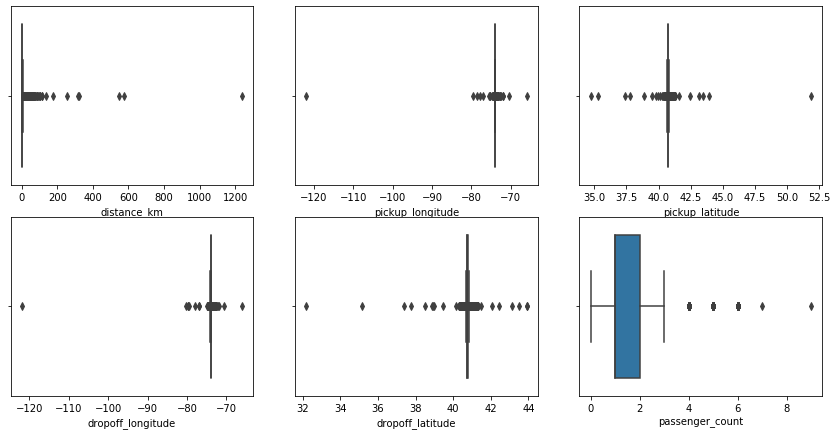

In [ ]:
plot_numerical(df)

Let us find out number of distances greater than 50 kms

In [ ]:
df_temp = df[df['distance_km'] > 50]
df_temp.shape

(51, 19)

Out of some 700,000 trips, only 51 have covered distances greater than 50 kms. Hence it would be safe to drop these rows from the dataset. Let's also plot the numerical features after removing these columns

In [ ]:
print("Rows before : ",df.shape[0])
df = df[df['distance_km'] <= 50]
print("Rows after : ",df.shape[0])

Rows before :  729322
Rows after :  729271


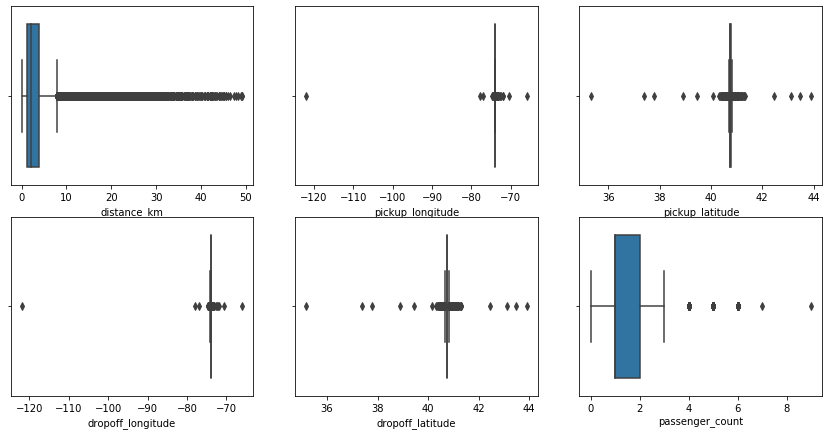

In [ ]:
plot_numerical(df)

### Counting outliers in each column using formula method

In [ ]:
#Finds number of outliers in a dataframe column using formula method
def find_outliers(df_column):
  q1 = df_column.quantile(0.25)
  q2 = df_column.quantile(0.5)
  q3 = df_column.quantile(0.75)
  q4 = df_column.quantile(1)
  lower = q1 - 1.5*(q3-q1)
  upper = q3 + 1.5*(q3-q1)
  #print(lower,upper)
  #df_temp = df[df['distance_km'] > 50]
  df_temp = df_column.apply(lambda x: (x > upper or x < lower)) #df_column > upper or df_column < lower
  df_outlier = df_column[df_column == True]
  print("% outliers using formula method")
  print(df_outlier.shape[0]*100/df_column.shape[0])  


passenger_count	pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude	trip_duration	distance_km	

In [ ]:
numeric_cols = ['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance_km']

Using formula method to find outliers

In [ ]:
for col in numeric_cols:
  print(col)
  find_outliers(df[col])

passenger_count
% outliers using formula method
70.94482023829276
pickup_longitude
% outliers using formula method
0.0
pickup_latitude
% outliers using formula method
0.0
dropoff_longitude
% outliers using formula method
0.0
dropoff_latitude
% outliers using formula method
0.0
distance_km
% outliers using formula method
0.3384201483399175


### Using percentile method

In [ ]:
#find percentiles for a data
def find_percentiles(df_column,start,end,interval):
  for i in range(start,end,interval):
    var = np.sort(df_column.values,axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var) * (float(i)/100))]))

  print("100 percentile value is: ",var[-1])

In [ ]:
#Overall
for col in numeric_cols:
  print("For",col)
  find_percentiles(df[col],0,100,10)

For passenger_count
0 percentile value is 0
10 percentile value is 1
20 percentile value is 1
30 percentile value is 1
40 percentile value is 1
50 percentile value is 1
60 percentile value is 1
70 percentile value is 1
80 percentile value is 2
90 percentile value is 4
100 percentile value is:  9
For pickup_longitude
0 percentile value is -121.93334197998048
10 percentile value is -74.00266265869139
20 percentile value is -73.99427795410156
30 percentile value is -73.98997497558594
40 percentile value is -73.9857864379883
50 percentile value is -73.98175811767578
60 percentile value is -73.97725677490234
70 percentile value is -73.97139739990234
80 percentile value is -73.96233367919923
90 percentile value is -73.95187377929686
100 percentile value is:  -65.89738464355469
For pickup_latitude
0 percentile value is 35.310306549072266
10 percentile value is 40.72018051147461
20 percentile value is 40.73225021362305
30 percentile value is 40.74131774902344
40 percentile value is 40.74843978

In [ ]:
#Between 90 and 100 percentile
for col in numeric_cols:
  print("For",col)
  find_percentiles(df[col],90,100,1)

For passenger_count
90 percentile value is 4
91 percentile value is 4
92 percentile value is 5
93 percentile value is 5
94 percentile value is 5
95 percentile value is 5
96 percentile value is 5
97 percentile value is 6
98 percentile value is 6
99 percentile value is 6
100 percentile value is:  9
For pickup_longitude
90 percentile value is -73.95187377929686
91 percentile value is -73.95018768310547
92 percentile value is -73.9478988647461
93 percentile value is -73.94512939453125
94 percentile value is -73.93692016601562
95 percentile value is -73.89190673828125
96 percentile value is -73.87269592285155
97 percentile value is -73.86347961425781
98 percentile value is -73.79019927978516
99 percentile value is -73.78224182128906
100 percentile value is:  -65.89738464355469
For pickup_latitude
90 percentile value is 40.78039932250977
91 percentile value is 40.78155517578125
92 percentile value is 40.7829704284668
93 percentile value is 40.78440475463867
94 percentile value is 40.78609848

Based on the above results, we can try removing data above 99 percentile for distance_kms and passenger count. This way we remove rows with extreme outliers

In [ ]:
df1 = df.copy()

for col in ['distance_km','passenger_count']:
   #print(col)
   #print(df1[col].quantile(.98))
   df1 = df1[df1[col] <= df1[col].quantile(.99)]
   # print(df1.shape[0])

print("Initial rows: ",df.shape[0])
print("After removing above 99 percentile rows: ",df1.shape[0])
print("Number of removed rows", df.shape[0] - df1.shape[0])
print("% of removed rows", (df.shape[0] - df1.shape[0])*100/df.shape[0] ) 

Initial rows:  729271
After removing above 99 percentile rows:  722022
Number of removed rows 7249
% of removed rows 0.9940063433209329


In [ ]:
df = df1.copy()

# Check skew of variables

In [ ]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance_km', 'pickup_timestamp', 'pickup_year',
       'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_day_of_week',
       'pickup_hour_binned'],
      dtype='object')

In [ ]:
df.shape

(722022, 19)

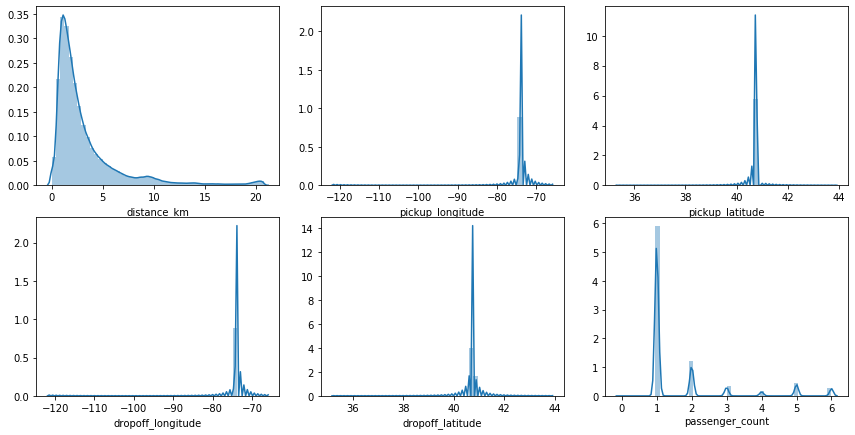

In [ ]:
fig, axes = plt.subplots(nrows = 2 , ncols = 3, figsize=(12, 6))
fig.tight_layout()
ax1,ax2,ax3,ax4,ax5,ax6 = axes[0][0] , axes[0][1],axes[0][2] , axes[1][0] , axes[1][1], axes[1][2] 


sns.distplot(df['distance_km'],kde=True,ax = ax1)
sns.distplot(df['pickup_longitude'],kde=True,ax = ax2)
sns.distplot(df['pickup_latitude'],kde=True,ax = ax3)
sns.distplot(df['dropoff_longitude'],kde=True,ax = ax4)
sns.distplot(df['dropoff_latitude'],kde=True,ax = ax5) 
sns.distplot(df['passenger_count'],kde=True,ax = ax6)
'''
sns.relplot(x="distance_km", y="trip_duration", data=df1, kind="scatter",ax=ax1)
sns.relplot(x="pickup_longitude", y="trip_duration", data=df1, kind="scatter",ax=ax2)
sns.relplot(x="pickup_latitude", y="trip_duration", data=df1, kind="scatter",ax=ax3)
sns.relplot(x="dropoff_longitude", y="trip_duration", data=df1, kind="scatter",ax=ax4)
sns.relplot(x="dropoff_latitude", y="trip_duration", data=df1, kind="scatter",ax=ax5)
sns.relplot(x="passenger_count", y="trip_duration", data=df1, kind="scatter",ax=ax6)
'''
plt.show()

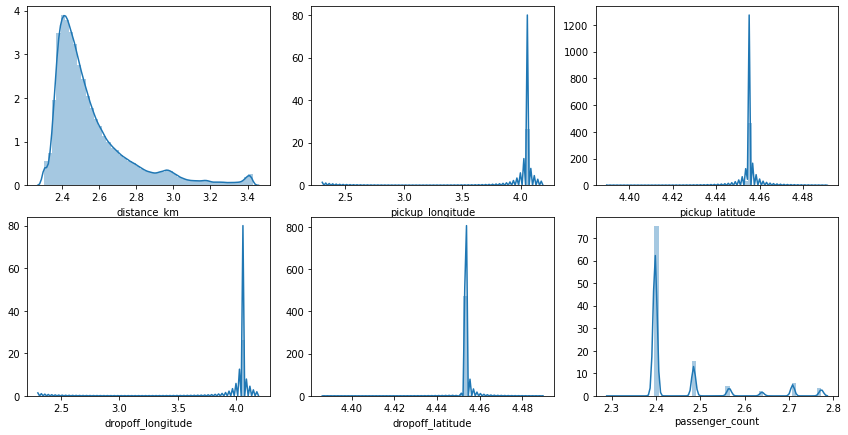

In [ ]:
fig, axes = plt.subplots(nrows = 2 , ncols = 3, figsize=(12, 6))
fig.tight_layout()
ax1,ax2,ax3,ax4,ax5,ax6 = axes[0][0] , axes[0][1],axes[0][2] , axes[1][0] , axes[1][1], axes[1][2] 

#temp = np.log(df[column] + abs(df1[column].min()) + 10)
temp = np.log(df['distance_km'] + abs(df['distance_km'].min()) + 10)
sns.distplot(temp,kde=True,ax = ax1)

temp = np.log(df['pickup_longitude'] + abs(df['pickup_longitude'].min()) + 10)
sns.distplot(temp,kde=True,ax = ax2)

temp = np.log(df['pickup_latitude'] + abs(df['pickup_latitude'].min()) + 10)
sns.distplot(temp,kde=True,ax = ax3)

temp = np.log(df['dropoff_longitude'] + abs(df['dropoff_longitude'].min()) + 10)
sns.distplot(temp,kde=True,ax = ax4)

temp = np.log(df['dropoff_latitude'] + abs(df['dropoff_latitude'].min()) + 10)
sns.distplot(temp,kde=True,ax = ax5)

temp = np.log(df['passenger_count'] + abs(df['passenger_count'].min()) + 10) 
sns.distplot(temp,kde=True,ax = ax6)



plt.show()

# Check relationships between independent and dependent variables

In [ ]:
'''
sns.relplot(x="distance_km", y="trip_duration", data=df, kind="scatter",ax=ax1)
sns.relplot(x="pickup_longitude", y="trip_duration", data=df, kind="scatter",ax=ax2)
sns.relplot(x="pickup_latitude", y="trip_duration", data=df, kind="scatter",ax=ax3)
sns.relplot(x="dropoff_longitude", y="trip_duration", data=df, kind="scatter",ax=ax4)
sns.relplot(x="dropoff_latitude", y="trip_duration", data=df, kind="scatter",ax=ax5)
sns.relplot(x="passenger_count", y="trip_duration", data=df, kind="scatter",ax=ax6)
'''

'\nsns.relplot(x="distance_km", y="trip_duration", data=df, kind="scatter",ax=ax1)\nsns.relplot(x="pickup_longitude", y="trip_duration", data=df, kind="scatter",ax=ax2)\nsns.relplot(x="pickup_latitude", y="trip_duration", data=df, kind="scatter",ax=ax3)\nsns.relplot(x="dropoff_longitude", y="trip_duration", data=df, kind="scatter",ax=ax4)\nsns.relplot(x="dropoff_latitude", y="trip_duration", data=df, kind="scatter",ax=ax5)\nsns.relplot(x="passenger_count", y="trip_duration", data=df, kind="scatter",ax=ax6)\n'

# Data preprocessing and Feature Selection 

## For numeric data

In [ ]:
df.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance_km
count,722022.000000,722022.000000,722022.000000,722022.000000,722022.000000,7.220220e+05,722022.000000
mean,1.661055,-73.974695,40.751540,-73.973996,40.751941,9.292586e+02,3.242743
std,1.312254,0.067797,0.028986,0.066990,0.033219,3.850801e+03,3.426521
min,0.000000,-121.933342,35.310307,-121.933304,35.173546,1.000000e+00,0.000000
25%,1.000000,-73.991936,40.737740,-73.991333,40.736111,3.940000e+02,1.230000
50%,1.000000,-73.981857,40.754269,-73.979797,40.754498,6.570000e+02,2.070000
75%,2.000000,-73.967766,40.768391,-73.963264,40.769707,1.058000e+03,3.780000
max,6.000000,-65.897385,43.911762,-65.897385,43.911762,1.939736e+06,20.790000


### Taking log of numerical variables

In [ ]:
for column in numeric_cols:
  df[column] = np.log(df[column] + abs(df[column].min()) + 10) #ensuring that our column has only positive values
  

In [ ]:
df[numeric_cols].describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_km
count,722022.000000,722022.000000,722022.000000,722022.000000,722022.000000,722022.000000
mean,2.450732,4.059728,4.455066,4.059740,4.453480,2.558407
std,0.101584,0.002166,0.000337,0.002159,0.000387,0.209505
min,2.302585,2.302585,4.389754,2.302585,4.386356,2.302585
25%,2.397895,4.059432,4.454906,4.059442,4.453296,2.418589
50%,2.397895,4.059606,4.455098,4.059641,4.453510,2.490723
75%,2.484907,4.059849,4.455262,4.059926,4.453687,2.623218
max,2.772589,4.190199,4.491128,4.190199,4.489594,3.427190


## For categorical variables

### One hot encoding for categorical variables

In [ ]:
def one_hot_encoding(data,cat_feats):
  one_hot = pd.get_dummies(data[cat_feats],drop_first=True)
  data = pd.concat([data,one_hot],axis=1)
  #data = data.drop(cat_feats,axis = 1)
  return data

# TODO: 

0. Check alternative to MAE as evaluation metric
1. Use dimensionality reduction techniques. Use z-test/t-test to compare categorical and target variable.
2. Apply Lasso and Ridge regression. Re-watch the video for this.
3. Add a cross-validation section
4. Select features based on co-efficients from all variables. Refer Model Interpretability section [here](https://colab.research.google.com/drive/15aiqo_lSvYJnpHUOtGKzkyzktzTwiMkM#scrollTo=pAQY_EKnGpZ3)


5. Check skewness of variables
6. Check relation between independent and dependent variables

# Checking assumptions of linear models

In [ ]:
def calc_residual(test_y,test_predict):
  # Arranging and calculating the Residuals
  residuals = pd.DataFrame({
      'fitted values' : test_y,
      'predicted values' : test_predict,
  })

  residuals['residuals'] = residuals['fitted values'] - residuals['predicted values']
  print("Residuals")
  print(residuals.head())

  return residuals

In [ ]:
# For checking if our residuals/erros have a pattern
def plot_residuals(residuals):
  #print()
  plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
  length = len(residuals.residuals[:])
  f = range(0,length)
  k = [0 for i in range(0,length)] #will help in setting limits for x-axis
  plt.scatter( f, residuals.residuals[:], label = 'residuals')
  plt.plot( f, k , color = 'red', label = 'regression line' )
  plt.xlabel('fitted points ')
  plt.ylabel('residuals')
  plt.title('Residual plot')
  plt.ylim(-4000, 4000)
  plt.legend()

Histogram is used to check for normality of residuals.

Normality of residual terms ensures that there is not non-linearity present in the data and rest of the assumptions of Linear Regression are followed.

In [ ]:
def histogram(residuals):
  # Histogram for distribution
  plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
  plt.hist(residuals.residuals, bins = 150)
  plt.xlabel('Error')
  plt.ylabel('Frequency')
  plt.title('Distribution of Error Terms')
  plt.xlim(0,15000)
  plt.show()

In [ ]:
def qq_plot(residuals):
  ## Plotting the QQ plot
  fig, ax = plt.subplots(figsize=(5,5) , dpi = 120)
  qqplot(residuals.residuals, line = 's' , ax = ax)
  plt.ylabel('Residual Quantiles')
  plt.xlabel('Ideal Scaled Quantiles')
  plt.title('Checking distribution of Residual Errors')
  plt.show()

# Variance Inflation Factor (VIF) (Checking for multi collinearity)

In [ ]:
def vif(data):
  # Importing Variance_inflation_Factor funtion from the Statsmodels
  from statsmodels.stats.outliers_influence import variance_inflation_factor
  from statsmodels.tools.tools import add_constant

  # Calculating VIF for every column (only works for the not Catagorical)
  VIF = pd.Series([variance_inflation_factor(data.values, i) for i in range(data.shape[1])], index =data.columns)
  print(VIF)

# Lasso and Ridge regression function

In [ ]:
#Importing Lasso model from sklearn's linear_model module
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [ ]:
#Define the alpha values to test
alpha_ridge = [0, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20, 25]
alpha_lasso = [0, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

In [ ]:
# defining a function which will fit lasso regression model, plot the results, and return the coefficients
def lasso_regression(train_x, train_y, test_x, test_y, alpha, models_to_plot={}):
    print("alpha = ",alpha)
    #Fit the model
    if alpha == 0:
        lassoreg = LinearRegression(normalize=True)
        lassoreg.fit(train_x, train_y)
        train_y_pred = lassoreg.predict(train_x)
        test_y_pred = lassoreg.predict(test_x)
        
    else:
        lassoreg = Lasso(alpha=alpha,normalize=True)
        lassoreg.fit(train_x,train_y)
        train_y_pred = lassoreg.predict(train_x)
        test_y_pred = lassoreg.predict(test_x)
    
    print("Model fitted")
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(train_x,train_y_pred) #train_x[:,0:1]
        plt.plot(train_x,train_y,'.') #train_x[:,0:1]
        plt.title('Plot for alpha: %.3g'%alpha)
    
    print("Plot complete")

    #Return the result in pre-defined format
    mrss_train = sum((train_y_pred-train_y)**2)/train_x.shape[0]
    ret = [mrss_train]
    
    mrss_test = sum((test_y_pred-test_y)**2)/test_x.shape[0]
    ret.extend([mrss_test])
    
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    
    return ret

In [ ]:
# defining a function which will fit ridge regression model, plot the results, and return the coefficients
def ridge_regression(train_x, train_y, test_x, test_y, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(train_x,train_y)
    train_y_pred = ridgereg.predict(train_x)
    test_y_pred = ridgereg.predict(test_x)
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(train_x,train_y_pred)
        plt.plot(train_x,train_y,'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    mrss_train = sum((train_y_pred-train_y)**2)/train_x.shape[0]
    ret = [mrss_train]
    
    mrss_test = sum((test_y_pred-test_y)**2)/test_x.shape[0]
    ret.extend([mrss_test])
    
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    
    return ret

# Storing a copy of our original dataframe and results


In [ ]:
df_copy = df.copy()
# Stores results of all experiments
train_results = {}
test_results = {}

# Checking for all features

In [ ]:
# checking data types of all features
df.dtypes

id                      object
vendor_id               object
pickup_datetime         object
dropoff_datetime        object
passenger_count        float64
pickup_longitude       float64
pickup_latitude        float64
dropoff_longitude      float64
dropoff_latitude       float64
store_and_fwd_flag      object
trip_duration            int64
distance_km            float64
pickup_timestamp        object
pickup_year             object
pickup_month            object
pickup_day              object
pickup_hour             object
pickup_day_of_week      object
pickup_hour_binned    category
dtype: object

In [ ]:
categorical_features = ['vendor_id','pickup_datetime','dropoff_datetime','store_and_fwd_flag','pickup_timestamp','pickup_year','pickup_month','pickup_day','pickup_hour','pickup_day_of_week','pickup_hour_binned']

### Dropping some features
We will drop categorical features having high count of unique features, as these will not be helpful in analysis and processing them will be a computationally expensive operation.

In [ ]:
for i in range(0,len(categorical_features)):
    print(str(categorical_features[i]) + " - Number of Unique Values: " + str(df[categorical_features[i]].nunique()))

vendor_id - Number of Unique Values: 2
pickup_datetime - Number of Unique Values: 702436
dropoff_datetime - Number of Unique Values: 702349
store_and_fwd_flag - Number of Unique Values: 2
pickup_timestamp - Number of Unique Values: 702436
pickup_year - Number of Unique Values: 1
pickup_month - Number of Unique Values: 6
pickup_day - Number of Unique Values: 31
pickup_hour - Number of Unique Values: 24
pickup_day_of_week - Number of Unique Values: 7
pickup_hour_binned - Number of Unique Values: 4


We can drop pickup_datetime,dropoff_datetime, pickup_timestamp  as they all have unique values, and won't be useful in providing insights


In [ ]:
df = df.drop(['pickup_datetime','dropoff_datetime', 'pickup_timestamp'],axis=1)

# Removing values from categorical features list
categorical_features.remove('pickup_datetime')
categorical_features.remove('dropoff_datetime')
categorical_features.remove('pickup_timestamp')

In [ ]:
# initially 20 columns
print(df.shape)
#len(categorical_features)

(722022, 16)


In [ ]:
df = one_hot_encoding(df,categorical_features)

In [ ]:
df.drop(categorical_features,axis=1,inplace=True)

In [ ]:
print(df.shape)

(722022, 77)


In [ ]:
df.columns

Index(['id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'distance_km',
       'vendor_id_2', 'store_and_fwd_flag_Y', 'pickup_month_02',
       'pickup_month_03', 'pickup_month_04', 'pickup_month_05',
       'pickup_month_06', 'pickup_day_02 ', 'pickup_day_03 ', 'pickup_day_04 ',
       'pickup_day_05 ', 'pickup_day_06 ', 'pickup_day_07 ', 'pickup_day_08 ',
       'pickup_day_09 ', 'pickup_day_10 ', 'pickup_day_11 ', 'pickup_day_12 ',
       'pickup_day_13 ', 'pickup_day_14 ', 'pickup_day_15 ', 'pickup_day_16 ',
       'pickup_day_17 ', 'pickup_day_18 ', 'pickup_day_19 ', 'pickup_day_20 ',
       'pickup_day_21 ', 'pickup_day_22 ', 'pickup_day_23 ', 'pickup_day_24 ',
       'pickup_day_25 ', 'pickup_day_26 ', 'pickup_day_27 ', 'pickup_day_28 ',
       'pickup_day_29 ', 'pickup_day_30 ', 'pickup_day_31 ', 'pickup_hour_01',
       'pickup_hour_02', 'pickup_hour_03', 'pickup_hour_04', 'pickup_hour_05',
       '

In [ ]:
numeric_cols = ['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance_km','trip_duration']

We will drop passenger_count variable 
Dropping id as it doesn't provide any insight




In [ ]:
df.drop(['id'],axis=1,inplace=True)

In [ ]:
df.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'distance_km',
       'vendor_id_2', 'store_and_fwd_flag_Y', 'pickup_month_02',
       'pickup_month_03', 'pickup_month_04', 'pickup_month_05',
       'pickup_month_06', 'pickup_day_02 ', 'pickup_day_03 ', 'pickup_day_04 ',
       'pickup_day_05 ', 'pickup_day_06 ', 'pickup_day_07 ', 'pickup_day_08 ',
       'pickup_day_09 ', 'pickup_day_10 ', 'pickup_day_11 ', 'pickup_day_12 ',
       'pickup_day_13 ', 'pickup_day_14 ', 'pickup_day_15 ', 'pickup_day_16 ',
       'pickup_day_17 ', 'pickup_day_18 ', 'pickup_day_19 ', 'pickup_day_20 ',
       'pickup_day_21 ', 'pickup_day_22 ', 'pickup_day_23 ', 'pickup_day_24 ',
       'pickup_day_25 ', 'pickup_day_26 ', 'pickup_day_27 ', 'pickup_day_28 ',
       'pickup_day_29 ', 'pickup_day_30 ', 'pickup_day_31 ', 'pickup_hour_01',
       'pickup_hour_02', 'pickup_hour_03', 'pickup_hour_04', 'pickup_hour_05',
       'pickup

### Splitting the dataset

Here Y is the dependent variable and X is the set of independent variables

In [ ]:
y = df.trip_duration
X = df.drop(['trip_duration'],axis=1)

In [ ]:
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=1/3, random_state=11)

### Fitting the model


In [ ]:
model = LinearRegression()
model.fit(xtrain,ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
# Predicting over the Train Set and calculating error
train_predict = model.predict(xtrain)
all_train_err = mae(train_predict, ytrain)
print('Training Mean Absolute Error', all_train_err )

Training Mean Absolute Error 394.30160062633877


In [ ]:
# Predicting over the test Set and calculating error
test_predict = model.predict(xtest)
all_test_err = mae(test_predict, ytest)
print('testing Mean Absolute Error', all_test_err )

testing Mean Absolute Error 420.1612654735195


In [ ]:
train_results['all_train_err'] = all_train_err
test_results['all_test_err'] = all_test_err

### Checking assumptions for model

In [ ]:
residuals = calc_residual(ytest,test_predict)

Residuals
        fitted values  predicted values   residuals
42955             545        742.948103 -197.948103
500501            690        789.371802  -99.371802
718824            654        489.127791  164.872209
159412           1031        653.104353  377.895647
460925            410        869.588728 -459.588728


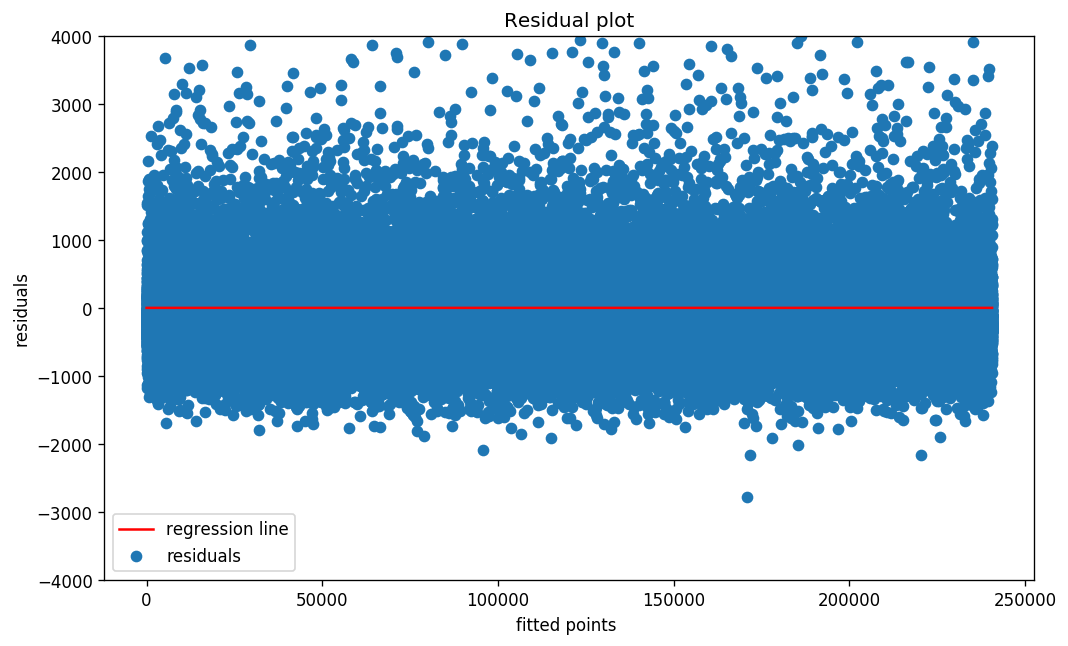

In [ ]:
plot_residuals(residuals)

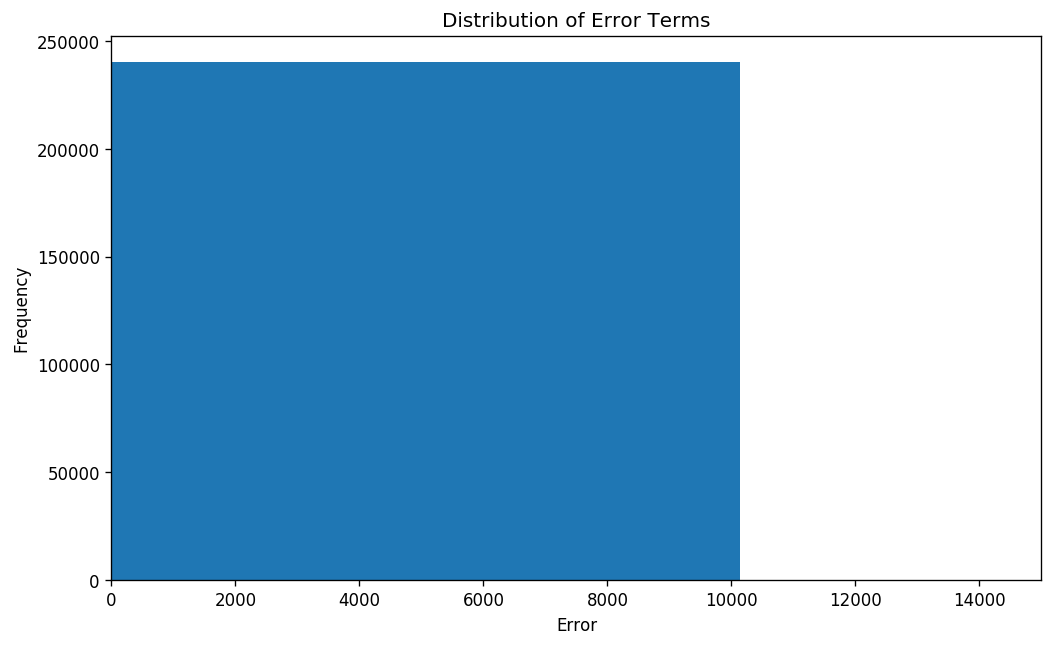

In [ ]:
histogram(residuals)

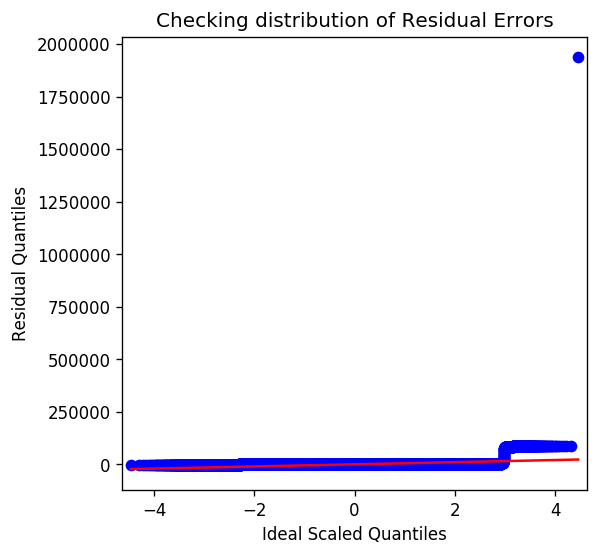

In [ ]:
qq_plot(residuals)

# Splitting the dataset for Ridge and Lasso Regression

Here Y is the dependent variable and X is the set of independent variables

In [ ]:
y = df.trip_duration
X = df.drop(['trip_duration'],axis=1)

In [ ]:
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25, random_state=11)

In [ ]:
xtrain.shape

(541516, 75)

# Lasso and Ridge Regression

### Applying Lasso Regression

In [ ]:
col = ['mrss_train','mrss_test','intercept'] + ['coef_Var_%d'%i for i in range(0,X.shape[1])]
ind = ['a_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

In [ ]:
#Define the models to plot
models_to_plot = {0:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

alpha =  0
Model fitted
Plot complete
alpha =  1e-10
Model fitted
Plot complete
alpha =  1e-08
Model fitted
Plot complete
alpha =  1e-05
Model fitted
Plot complete
alpha =  0.0001
Model fitted
Plot complete
alpha =  0.001
Model fitted
Plot complete
alpha =  0.01
Model fitted
Plot complete
alpha =  1
Model fitted
Plot complete
alpha =  5
Model fitted
Plot complete
alpha =  10
Model fitted
Plot complete


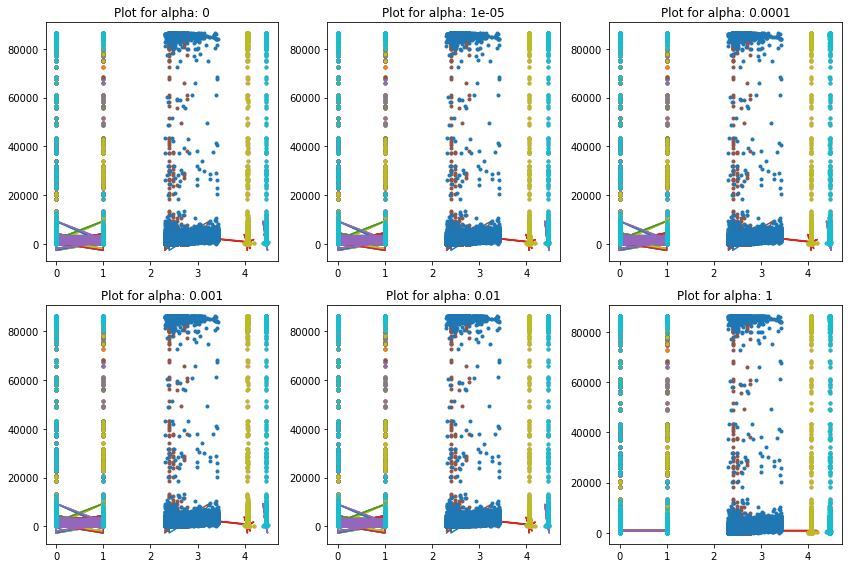

In [ ]:
plt.figure(figsize=(12,8))
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(xtrain, ytrain, xtest, ytest, alpha_lasso[i], models_to_plot)

In [ ]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso

,mrss_train,mrss_test,intercept,coef_Var_0,coef_Var_1,coef_Var_2,coef_Var_3,coef_Var_4,coef_Var_5,coef_Var_6,coef_Var_7,coef_Var_8,coef_Var_9,coef_Var_10,coef_Var_11,coef_Var_12,coef_Var_13,coef_Var_14,coef_Var_15,coef_Var_16,coef_Var_17,coef_Var_18,coef_Var_19,coef_Var_20,coef_Var_21,coef_Var_22,coef_Var_23,coef_Var_24,coef_Var_25,coef_Var_26,coef_Var_27,coef_Var_28,coef_Var_29,coef_Var_30,coef_Var_31,coef_Var_32,coef_Var_33,coef_Var_34,coef_Var_35,coef_Var_36,coef_Var_37,coef_Var_38,coef_Var_39,coef_Var_40,coef_Var_41,coef_Var_42,coef_Var_43,coef_Var_44,coef_Var_45,coef_Var_46,coef_Var_47,coef_Var_48,coef_Var_49,coef_Var_50,coef_Var_51,coef_Var_52,coef_Var_53,coef_Var_54,coef_Var_55,coef_Var_56,coef_Var_57,coef_Var_58,coef_Var_59,coef_Var_60,coef_Var_61,coef_Var_62,coef_Var_63,coef_Var_64,coef_Var_65,coef_Var_66,coef_Var_67,coef_Var_68,coef_Var_69,coef_Var_70,coef_Var_71,coef_Var_72,coef_Var_73,coef_Var_74
a_0,9.1e+06,3.1e+07,4.3e+05,2.5e+02,1.1e+03,3.4e+04,-9.8e+02,-1.3e+05,2.4e+03,1.9e+02,14,-10,21,55,77,61,-26,-14,-4,-10,14,-53,-3.1,-30,-28,-15,-35,8.9,22,7.6,-15,11,-9.6,-9.1,8.1,-17,-0.12,15,40,4,-11,-0.5,-13,-13,-20,-21,38,32,4,-1e+02,-2.4e+02,9e+15,9e+15,9e+15,9e+15,9e+15,9e+15,5e+15,5e+15,5e+15,5e+15,5e+15,5e+15,3e+15,3e+15,3e+15,3e+15,3e+15,3e+15,-1.4e+02,-67,-1.5e+02,13,-27,-23,-9e+15,-5e+15,-3e+15
a_1e-10,9.1e+06,3.1e+07,4.3e+05,2.3e+02,2e+03,3.4e+04,-2e+03,-1.3e+05,2.4e+03,1.9e+02,12,-8.8,20,57,79,64,-29,-9.1,2.6,-7.4,8.7,-59,-3.3,-20,-29,-16,-34,17,23,25,-17,13,-9.7,-10,5,-14,-30,15,35,1.7,-10,3.2,-13,-7,-25,-9.5,32,31,8.2,-96,-2.4e+02,-2.8e+02,-94,78,1.1e+02,98,1.1e+02,1.5e+02,1.2e+02,2.1e+02,2.2e+02,2.4e+02,1.5e+02,1.6e+02,64,-13,-34,-9.6,-56,-1.4e+02,-69,-1.5e+02,13,-27,-22,86,78,56
a_1e-08,9.1e+06,3.1e+07,4.3e+05,2.3e+02,2e+03,3.4e+04,-2e+03,-1.3e+05,2.4e+03,1.9e+02,12,-8.8,20,57,79,64,-29,-9.1,2.6,-7.4,8.7,-59,-3.3,-20,-29,-16,-34,17,23,25,-17,13,-9.7,-10,5,-14,-30,15,35,1.7,-10,3.2,-13,-7,-25,-9.5,32,31,8.2,-96,-2.4e+02,-2.8e+02,-94,78,1.1e+02,98,1.1e+02,1.5e+02,1.2e+02,2.1e+02,2.2e+02,2.4e+02,1.5e+02,1.6e+02,64,-13,-34,-9.6,-56,-1.4e+02,-69,-1.5e+02,13,-27,-22,86,78,56
a_1e-05,9.1e+06,3.1e+07,4.3e+05,2.3e+02,1.9e+03,3.4e+04,-1.9e+03,-1.3e+05,2.4e+03,1.9e+02,12,-8.8,20,57,79,64,-29,-8.8,2.9,-7.1,8.9,-59,-3,-20,-29,-15,-33,17,23,25,-17,13,-9.3,-9.7,5.3,-14,-30,15,36,2,-10,3.5,-13,-6.6,-25,-9.1,31,31,7.8,-96,-2.4e+02,-2.8e+02,-91,81,1.1e+02,1e+02,1.2e+02,1.2e+02,91,1.8e+02,1.9e+02,2.1e+02,1.2e+02,1.7e+02,74,-2.3,-23,1.1,-45,-1.4e+02,-69,-1.5e+02,13,-26,-22,83,1.1e+02,45
a_0.0001,9.1e+06,3.1e+07,4.3e+05,2.3e+02,1.2e+03,3.4e+04,-1.2e+03,-1.3e+05,2.4e+03,1.9e+02,11,-9.1,19,56,78,63,-26,-5.7,5.3,-3.9,11,-56,-0,-17,-26,-12,-30,19,25,27,-14,16,-6.3,-6.6,7.5,-11,-27,18,38,4.4,-6.8,5.7,-9.8,-3.5,-22,-5.9,28,27,4.3,-98,-2.4e+02,-2.6e+02,-74,97,1.3e+02,1.2e+02,1.3e+02,-0,-31,54,69,84,2.4,1.7e+02,77,0,-21,3.4,-42,-1.4e+02,-68,-1.5e+02,13,-26,-21,63,2.3e+02,39
a_0.001,9.1e+06,3.1e+07,4.4e+05,2.3e+02,0,3e+04,-0,-1.3e+05,2.4e+03,1.9e+02,2.1,-12,13,50,72,57,-19,-0,5.8,0,11,-48,0.19,-10,-19,-4.8,-22,18,26,28,-7.6,16,-0,-0,6.8,-3.6,-19,17,39,4.8,-0,4.6,-2.4,0,-15,-0,0.67,0,-13,-1.2e+02,-2.6e+02,-3.5e+02,-1.7e+02,0,27,20,34,-0,-29,50,65,80,0,1.7e+02,76,0,-16,3.1,-37,-1.3e+02,-62,-1.4e+02,16,-19,-12,1.4e+02,2e+02,14
a_0.01,9.1e+06,3.1e+07,4.3e+05,1.7e+02,0,0,-0,-9.7e+04,2.3e+03,1.8e+02,0,-19,-0,13,34,20,-0,0,0,0,0,-14,0,-0,-0,-0,-0,0,0,0,-0,0,-0,-0,0,-0,-0,0,6.6,0,-0,0,-0,0,-0,-0,-0,-0,-0,-82,-2.2e+02,-2.8e+02,-1.1e+02,0,17,7.9,22,-0,-0,23,37,50,0,1.3e+02,34,-0,-3.2,-0,-20,-91,-33,-1e+02,17,-0,0,86,1.7e+02,-0
a_1,9.4e+06,3.1e+07,9.2e+02,0,0,-0,0,-0,0,0,0,-0,-0,0,0,0,-0,0,-0,-0,0,-0,0,-0,-0,-0,-0,0,0,0,-0,0,-0,0,0,-0,-0,0,0,0,0,-0,-0,-0,-0,0,-0,-0,-0,-0,-0,-0,-0,-0,0,0,0,0,0,0,0,0,0,0,-0,-0,-0,-0,-0,-0,-0,-0,0,0,0,-0,0,-0
a_5,9.4e+06,3.1e+07,9.2e+02,0,0,-0,0,-0,0,0,0,-0,-0,0,0,0,-0,0,-0,-0,0,-0,0,-0,-0,-0,-0,0,0,0,-0,0,-0,0,0,-0,-0,0,0,0,0,-0,-0,-0,-0,0,-0,-0,-0,-0,-0,-0,-0,-0,0,0,0,0,0,0,0,0,0,0,-0,-0,-0,-0,-0,-0,-0,-0,0,0,0,-0

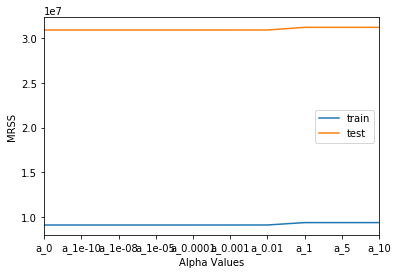

In [ ]:
coef_matrix_lasso[['mrss_train','mrss_test']].plot()
plt.xlabel('Alpha Values')
plt.ylabel('MRSS')
plt.legend(['train', 'test'])

a in above plot is alpha

In [ ]:
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)

a_0          0
a_1e-10      0
a_1e-08      0
a_1e-05      0
a_0.0001     3
a_0.001     14
a_0.01      45
a_1         75
a_5         75
a_10        75
dtype: int64

### Applying ridge regression

In [ ]:
col = ['mrss_train','mrss_test','intercept'] + ['coef_Var_%d'%i for i in range(0,X.shape[1])]
ind = ['a_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

In [ ]:
#Define the models to plot
models_to_plot = {0:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

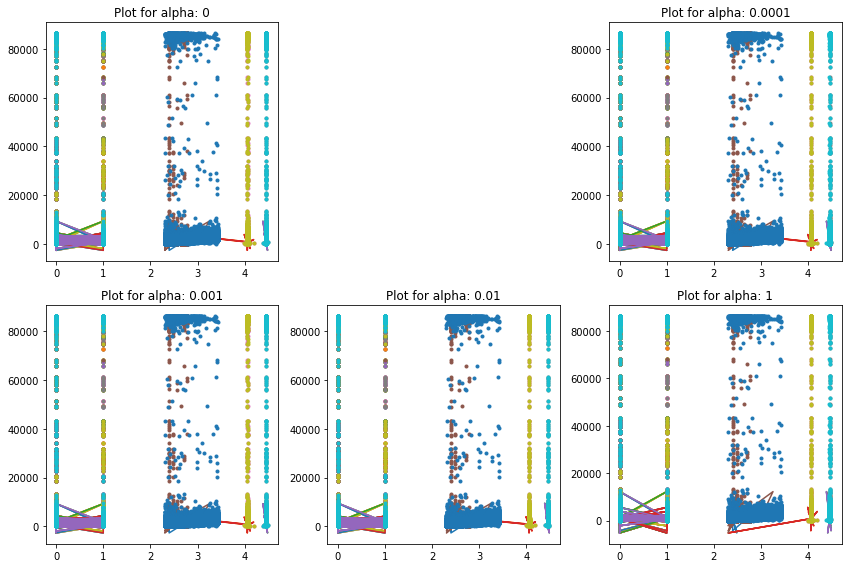

In [ ]:
plt.figure(figsize=(12,8))
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(xtrain, ytrain, xtest, ytest, alpha_ridge[i], models_to_plot)

In [ ]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,mrss_train,mrss_test,intercept,coef_Var_0,coef_Var_1,coef_Var_2,coef_Var_3,coef_Var_4,coef_Var_5,coef_Var_6,coef_Var_7,coef_Var_8,coef_Var_9,coef_Var_10,coef_Var_11,coef_Var_12,coef_Var_13,coef_Var_14,coef_Var_15,coef_Var_16,coef_Var_17,coef_Var_18,coef_Var_19,coef_Var_20,coef_Var_21,coef_Var_22,coef_Var_23,coef_Var_24,coef_Var_25,coef_Var_26,coef_Var_27,coef_Var_28,coef_Var_29,coef_Var_30,coef_Var_31,coef_Var_32,coef_Var_33,coef_Var_34,coef_Var_35,coef_Var_36,coef_Var_37,coef_Var_38,coef_Var_39,coef_Var_40,coef_Var_41,coef_Var_42,coef_Var_43,coef_Var_44,coef_Var_45,coef_Var_46,coef_Var_47,coef_Var_48,coef_Var_49,coef_Var_50,coef_Var_51,coef_Var_52,coef_Var_53,coef_Var_54,coef_Var_55,coef_Var_56,coef_Var_57,coef_Var_58,coef_Var_59,coef_Var_60,coef_Var_61,coef_Var_62,coef_Var_63,coef_Var_64,coef_Var_65,coef_Var_66,coef_Var_67,coef_Var_68,coef_Var_69,coef_Var_70,coef_Var_71,coef_Var_72,coef_Var_73,coef_Var_74
a_0,9.1e+06,3.1e+07,4.3e+05,2.3e+02,2e+03,3.4e+04,-2e+03,-1.3e+05,2.4e+03,1.9e+02,12,-8.8,20,57,79,64,-29,-9.1,2.6,-7.4,8.7,-59,-3.3,-20,-29,-16,-34,17,23,25,-17,13,-9.7,-10,5,-14,-30,15,35,1.7,-10,3.2,-13,-7,-25,-9.5,32,31,8.2,-96,-2.4e+02,-2.6e+02,-75,97,1.3e+02,1.2e+02,1.3e+02,81,50,1.4e+02,1.5e+02,1.7e+02,84,1.7e+02,73,-3.4,-25,0.078,-46,-1.4e+02,-69,-1.5e+02,13,-27,-22,67,1.5e+02,46
a_1e-08,9.1e+06,3.1e+07,4.3e+05,2.3e+02,2e+03,3.4e+04,-2e+03,-1.3e+05,2.4e+03,1.9e+02,12,-8.8,20,57,79,64,-29,-9.1,2.6,-7.4,8.7,-59,-3.3,-20,-29,-16,-34,17,23,25,-17,13,-9.7,-10,5,-14,-30,15,35,1.7,-10,3.2,-13,-7,-25,-9.5,32,31,8.2,-96,-2.4e+02,-2.6e+02,-75,97,1.3e+02,1.2e+02,1.3e+02,81,50,1.4e+02,1.5e+02,1.7e+02,84,1.7e+02,73,-3.4,-25,0.078,-46,-1.4e+02,-69,-1.5e+02,13,-27,-22,67,1.5e+02,46
a_0.0001,9.1e+06,3.1e+07,4.3e+05,2.3e+02,2e+03,3.4e+04,-2e+03,-1.3e+05,2.4e+03,1.9e+02,12,-8.8,20,57,79,64,-29,-9.1,2.6,-7.4,8.7,-59,-3.3,-20,-29,-16,-33,17,23,25,-17,13,-9.7,-10,5,-14,-30,15,35,1.7,-10,3.2,-13,-7,-25,-9.5,32,31,8.1,-96,-2.4e+02,-2.6e+02,-75,97,1.2e+02,1.2e+02,1.3e+02,81,50,1.4e+02,1.5e+02,1.7e+02,84,1.7e+02,73,-3.5,-25,0.024,-46,-1.4e+02,-69,-1.5e+02,13,-26,-22,67,1.5e+02,46
a_0.001,9.1e+06,3.1e+07,4.3e+05,2.3e+02,2e+03,3.4e+04,-2e+03,-1.3e+05,2.4e+03,1.9e+02,12,-9,20,57,79,63,-29,-9,2.8,-7.3,8.8,-59,-3.1,-20,-29,-16,-33,17,23,25,-17,13,-9.6,-9.9,5.2,-14,-30,15,35,1.9,-10,3.3,-13,-6.8,-25,-9.4,30,30,6.9,-97,-2.4e+02,-2.6e+02,-75,96,1.2e+02,1.2e+02,1.3e+02,80,49,1.3e+02,1.5e+02,1.6e+02,83,1.7e+02,73,-4,-25,-0.46,-47,-1.4e+02,-69,-1.5e+02,13,-26,-22,66,1.5e+02,45
a_0.01,9.1e+06,3.1e+07,4.4e+05,2.3e+02,2.4e+03,3e+04,-2.1e+03,-1.3e+05,2.3e+03,1.9e+02,13,-11,18,55,77,61,-28,-7.9,3.7,-6.2,9.6,-58,-1.5,-19,-28,-15,-32,18,23,26,-17,14,-8.5,-8.7,6,-14,-28,16,36,2.9,-8.9,4.1,-13,-5.2,-25,-9.1,19,18,-4.1,-1.1e+02,-2.5e+02,-2.6e+02,-79,90,1.2e+02,1.1e+02,1.2e+02,75,44,1.3e+02,1.4e+02,1.6e+02,78,1.6e+02,67,-8.7,-29,-4.7,-50,-1.3e+02,-65,-1.4e+02,16,-23,-19,59,1.4e+02,38
a_1,9.2e+06,3.1e+07,6.6e+05,1.9e+02,4.9e+03,-6.8e+04,2e+03,-8.8e+04,1.1e+03,98,29,-25,-3.8,15,29,22,-13,-0.88,2.7,-0.0021,3.9,-30,5.2,-9.6,-11,-8.4,-10,6.8,9.9,19,-7.5,11,-2,2.5,3.3,-6.4,-7.6,9.3,26,5.9,2.3,-0.036,-5.1,1.6,-8.9,-3.7,-28,-30,-34,-60,-1.2e+02,-1.4e+02,-60,14,26,25,32,16,4.9,53,60,69,24,44,-2.1,-30,-32,-14,-30,-44,-19,-46,30,7.7,13,-5,50,-13
a_5,9.3e+06,3.1e+07,3.5e+05,81,2.6e+03,-4.2e+04,1.5e+03,-4e+04,3.8e+02,34,14,-11,-2,4.1,9.8,7.7,-4.4,-0.047,0.062,-0.2,0.43,-10,1.6,-3.2,-3,-3.9,-2.9,1.3,3.2,6.6,-2.3,4.4,-0.88,1.6,0.63,-1.7,-2.3,3.1,9.6,2.2,1.4,-0.97,-1,0.078,-1.5,0.13,-5.9,-6.9,-6.8,-11,-28,-43,-22,0.23,3.7,3.7,6,5,2.7,20,22,26,9.7,9.2,-5.8,-12,-11,-3.4,-6.9,-14,-6.1,-12,11,2.7,5,-6.3,19,-7
a_10,9.3e+06,3.1e+07,2.1e+05,46,1.5e+03,-2.5e+04,9.6e+02,-2.4e+04,2.1e+02,19,8.5,-6.1,-1.1,2.2,5.4,4.3,-2.4,0.022,-0.12,-0.15,0.13,-5.6,0.85,-1.8,-1.5,-2.3,-1.6,0.57,1.7,3.6,-1.3,2.5,-0.53,0.95,0.29,-0.89,-1.2,1.7,5.3,1.2,0.86,-0.64,-0.46,-0.031,-0.62,0.3,-2.6,-3.1,-2.8,-4.3,-14,-23,-13,-0.64,1.2,1.3,2.6,2.9,1.8,11,13,15,5.6,4.3,-3.8,-6.9,-6.2,-1.7,-3.3,-7.4,-3.3,-6,5.9,1.4,2

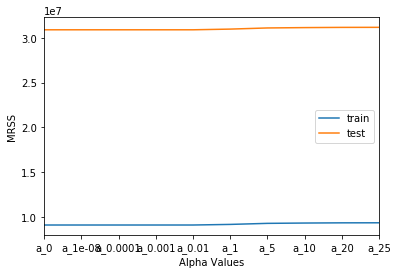

In [ ]:
coef_matrix_ridge[['mrss_train','mrss_test']].plot()
plt.xlabel('Alpha Values')
plt.ylabel('MRSS')
plt.legend(['train', 'test'])

In [ ]:
coef_matrix_ridge.apply(lambda x: sum(x.values==0),axis=1)

a_0         0
a_1e-08     0
a_0.0001    0
a_0.001     0
a_0.01      0
a_1         0
a_5         0
a_10        0
a_20        0
a_25        0
dtype: int64

From the data we can see that the data is non-linear and linear algorithms won't be very effective.